Source info: http://simbad.u-strasbg.fr/simbad/sim-id?Ident=PG+1553%2B113

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

Let's read our data using pandas tools

In [3]:
dt = pd.read_csv('4FGLJ1555 7p1111.txt',names=("MJD","Rate"),skiprows=3,sep=' ',usecols=[0,1])
print (dt)

              MJD          Rate
0    54697.656452  2.680909e-07
1    54727.654070  2.417409e-07
2    54757.652371  2.355980e-07
3    54787.651818  2.870907e-07
4    54817.652585  2.203087e-07
..            ...           ...
158  59437.660959  2.379877e-07
159  59467.660959  2.581184e-07
160  59497.660959  2.538550e-07
161  59527.660959  3.150496e-07
162  59558.026987  2.499752e-07

[163 rows x 2 columns]


Let's create simpler variable names to manage

In [4]:
X = dt['MJD']-dt['MJD'].min()
Y = np.log10(dt['Rate'])
#eY = dt['eRate']*1e7

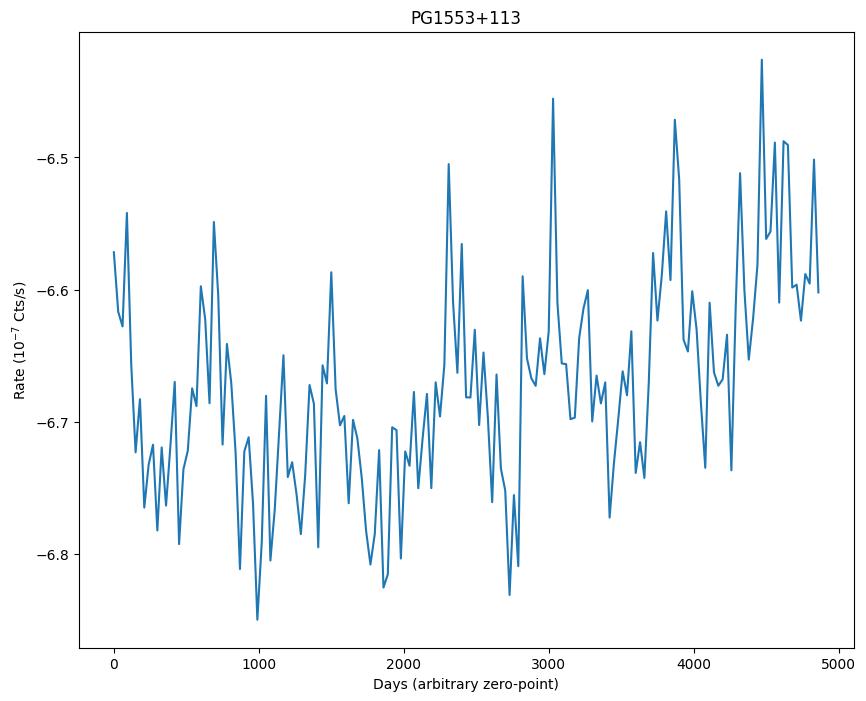

In [5]:
#plt.errorbar(X,Y,yerr=eY)
p = plt.figure(figsize=(10,8))
plt.plot(X,Y)
plt.xlabel("Days (arbitrary zero-point)")
plt.ylabel("Rate ($10^{-7}$ Cts/s)")
plt.title("PG1553+113");

In [6]:
#define function for ADF test
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(Y)

Results of Dickey-Fuller Test:
Test Statistic                  -3.170945
p-value                          0.021729
#Lags Used                       2.000000
Number of Observations Used    160.000000
Critical Value (1%)             -3.471896
Critical Value (5%)             -2.879780
Critical Value (10%)            -2.576495
dtype: float64


In [7]:
#define function for kpss test
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags='auto')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

kpss_test(Y)

Results of KPSS Test:
Test Statistic           0.894725
p-value                  0.010000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


So, I'd say we do not need to compute the difference of out light curve (*d=0*).

Let's try now to guess values for the AR and MA part of our ARIMA model.

In [8]:
lag_acf = acf(Y, nlags=20)
lag_pacf = pacf(Y, nlags=20, method='ols')

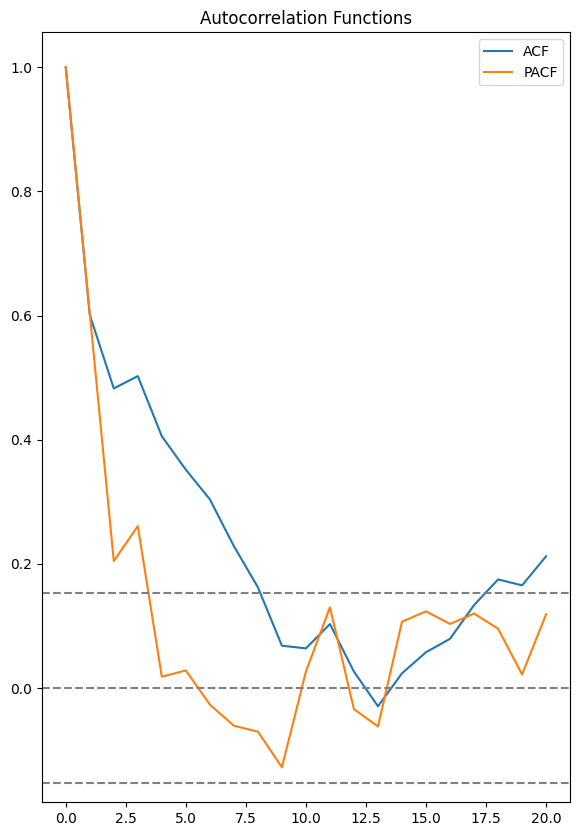

In [9]:
p = plt.figure(figsize=(15,10))
plt.subplot(121)
plt.plot(lag_acf,label='ACF')
plt.plot(lag_pacf,label='PACF')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dt)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dt)),linestyle='--',color='gray')
plt.legend()
plt.title('Autocorrelation Functions');

Just by eye, I estimate the last non-zero value at 7 or 8 for the ACF and 3 for the PACF.

In [ ]:
bic = {}
minbc = 1e6
for p in range(10):
    for q in range(10):
        model_ARIMA = ARIMA(Y, order=(p, 0, q))
        results_ARIMA = model_ARIMA.fit()
        print("p: ", p, "q: ", q, " BIC: ", results_ARIMA.bic, "MSE: ", results_ARIMA.mse, "AIC: ", results_ARIMA.aicc)
        if results_ARIMA.bic < minbc:
            minbc = results_ARIMA.bic
            bic['BIC'] = minbc
            bic['p'] = p
            bic['q'] = q
print(bic)

p:  0 q:  0  BIC:  -344.8687967155664 MSE:  0.006630092219658552 AIC:  -350.98129711717996
p:  0 q:  1  BIC:  -390.3289666194911 MSE:  0.004866154030199736 AIC:  -399.459273825685
p:  0 q:  2  BIC:  -392.4042308647224 MSE:  0.004659035939830044 AIC:  -404.52606711098747
p:  0 q:  3  BIC:  -402.53416124241454 MSE:  0.004244991421511214 AIC:  -417.6207466413528
p:  0 q:  4  BIC:  -402.5134490665381 MSE:  0.0041157260363903865 AIC:  -420.5374887329171
p:  0 q:  5  BIC:  -401.3140281132081 MSE:  0.0040176210333321685 AIC:  -422.24769887369416
p:  0 q:  6  BIC:  -401.69504893204754 MSE:  0.0038850804932602377 AIC:  -425.5099856034367
p:  0 q:  7  BIC:  -400.35770870882124 MSE:  0.0037961992155808475 AIC:  -427.0249899278468
p:  0 q:  8  BIC:  -398.1572897298655 MSE:  0.0037306899794070383 AIC:  -427.64742331688046
p:  0 q:  9  BIC:  -393.1082745462332 MSE:  0.003729752189764734 AIC:  -425.39118238424663
p:  1 q:  0  BIC:  -413.7173747737995 MSE:  0.004222257516943239 AIC:  -422.847681979993

In [10]:
model_ARIMA = ARIMA(Y, order=(1, 0, 1))
results_ARIMA = model_ARIMA.fit()

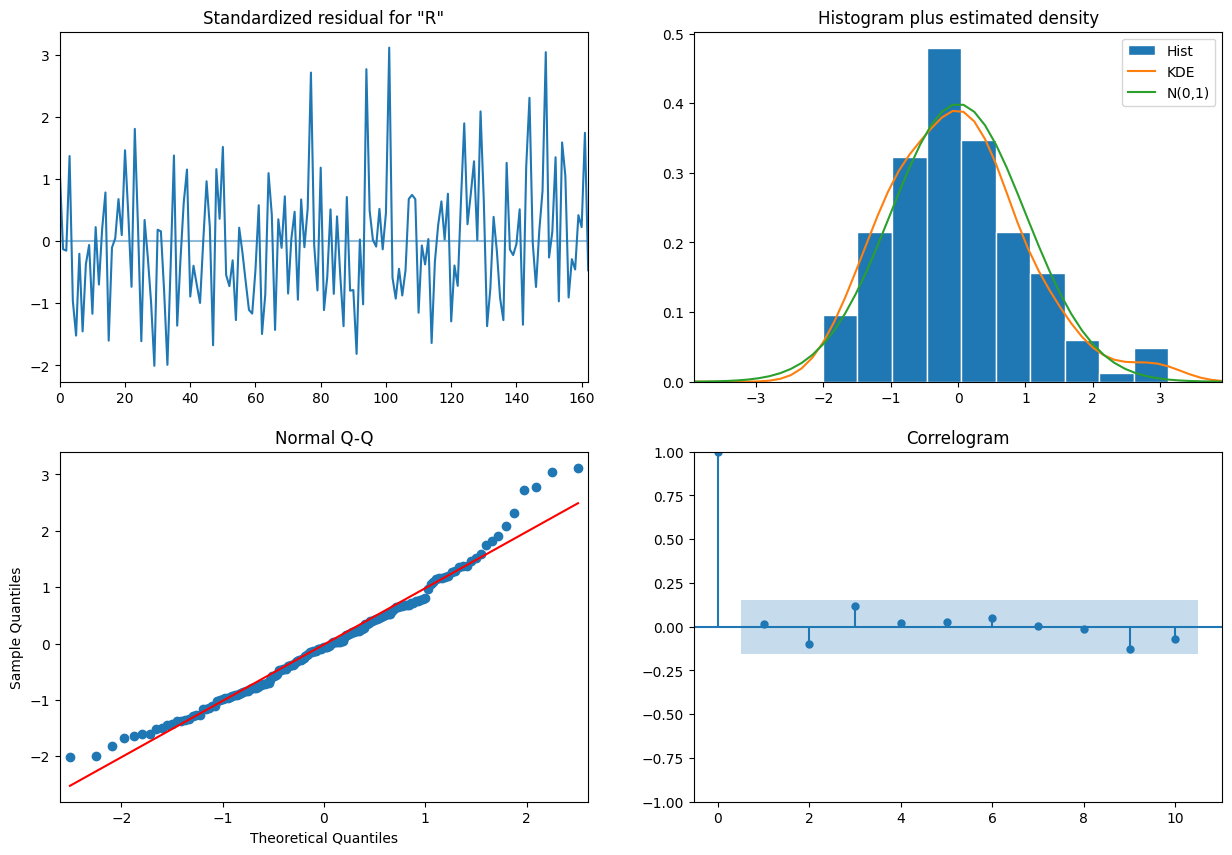

In [11]:
results_ARIMA.plot_diagnostics(figsize=(15,10));

Text(0.5, 1.0, 'ARMA fit')

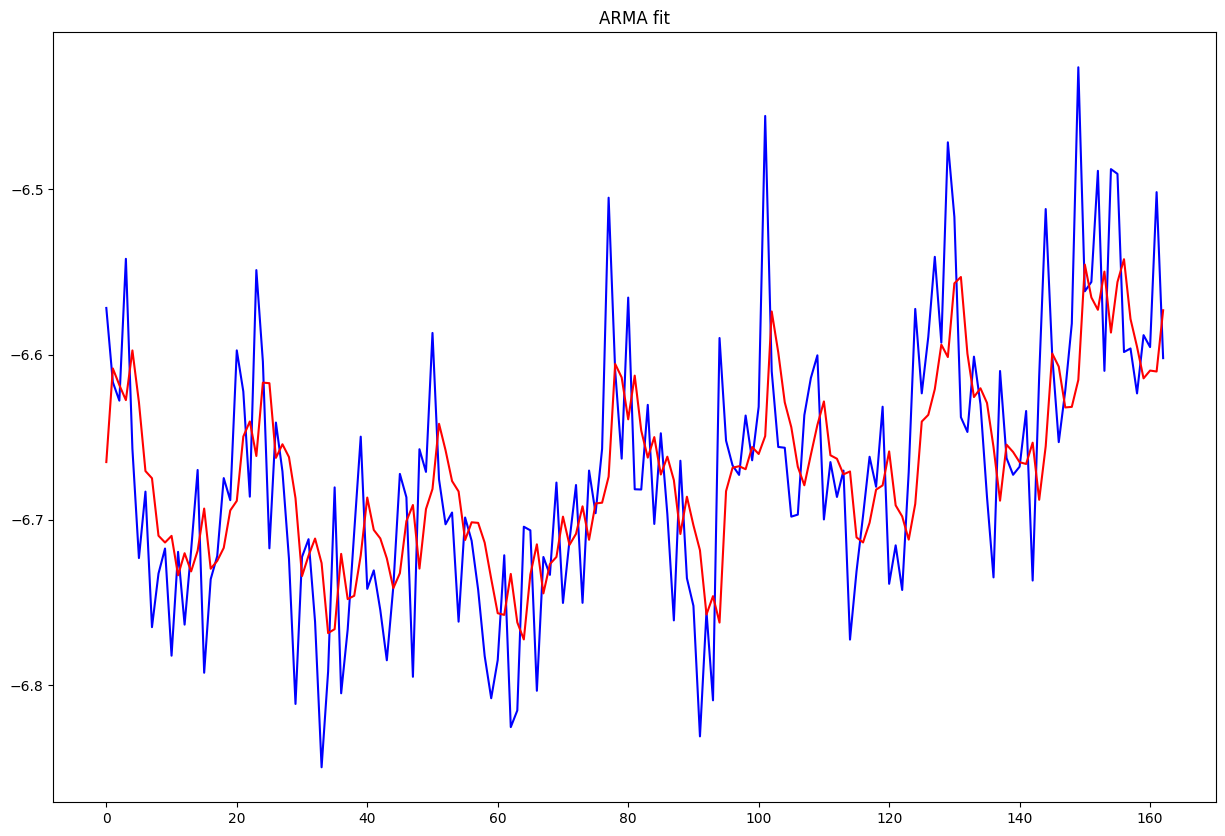

In [12]:
plt.figure(figsize=(15,10))
plt.plot(Y,color='blue')
plt.plot(results_ARIMA.predict(0,typ='levels'),color='red')
plt.title('ARMA fit')

And let's see now the *theoretical* ACF derived by our best-fit ARMA model

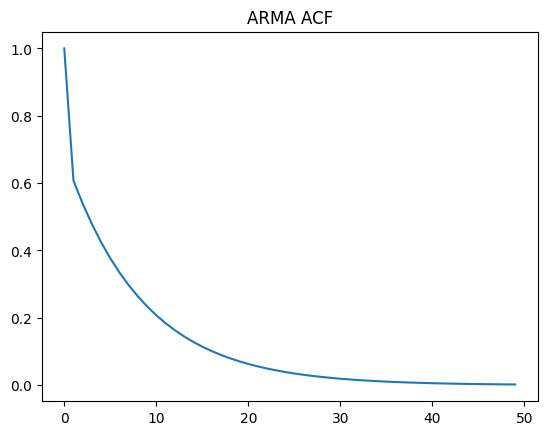

In [ ]:
import statsmodels.tsa.arima_process as stap
tacf = stap.arma_acf(results_ARIMA.polynomial_ar,results_ARIMA.polynomial_ma,50)
plt.plot(tacf)
plt.title('ARMA ACF');